In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn  as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import optuna as opt

c:\Users\Астемир\Desktop\Flower_project\fl_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv(os.path.join( "data", "IID.csv"))
test_data = pd.read_csv(os.path.join( "data", "TEST_SAMPLE.csv"))

In [3]:
train_data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeGroup,VehiclePrice_Cat,Fraud
0,7,5,4,17,1,5,1,4,1,1,...,0,0,0,0,1,0,0,-1.0,1,1
1,10,2,1,13,1,2,11,3,0,2,...,0,0,1,0,1,2,1,-1.0,1,0
2,7,4,0,5,1,1,1,1,1,3,...,0,0,6,0,1,2,0,-1.0,1,0
3,0,3,2,13,0,7,9,1,1,1,...,0,0,1,0,1,0,1,-1.0,1,0
4,5,3,4,9,1,1,2,1,1,1,...,0,0,0,0,1,2,2,-1.0,2,0


In [4]:
test_data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeGroup,VehiclePrice_Cat,Fraud
0,3,3,1,13,1,6,8,2,1,0,...,0,0,0,0,1,0,2,-1.0,0,0
1,6,3,0,9,1,7,7,4,1,1,...,0,0,0,0,1,1,1,-1.0,2,0
2,4,4,6,17,1,7,4,1,1,1,...,0,0,0,0,1,0,2,-1.0,1,0
3,4,3,1,13,1,7,4,1,1,1,...,0,0,0,0,1,1,2,-1.0,1,0
4,6,3,1,13,1,2,7,3,1,2,...,0,0,1,0,1,0,1,-1.0,2,0


In [7]:
features_set = [(train_data.columns)[:i] for i in range(5,16)]


In [8]:
def feature_skew_split(df, feature_cols, n_clients=6, n_clusters=10, seed=42):
    np.random.seed(seed)
  
    df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    X_scaled = StandardScaler().fit_transform(df_shuffled[feature_cols].values)
    
    clusters = KMeans(n_clusters=n_clusters, random_state=seed).fit_predict(X_scaled)
    df_shuffled['cluster'] = clusters
    
    cluster_counts = (df_shuffled.groupby('cluster').size()
                      .reset_index(name='count')
                      .sort_values(by='count', ascending=False)
                      .reset_index(drop=True))
    
    client_cluster_num = [n_clusters // n_clients + (1 if i < n_clusters % n_clients else 0) for i in range(n_clients)]
   
    cluster_assignment = {
        cluster_counts.loc[idx, 'cluster']: client_id 
        for client_id in range(n_clients)
        for idx in range(sum(client_cluster_num[:client_id]), sum(client_cluster_num[:client_id]) + client_cluster_num[client_id])
    }

    client_dfs = {
        client_id: df_shuffled[df_shuffled['cluster'].map(cluster_assignment) == client_id].drop(columns='cluster').copy()
        for client_id in range(n_clients)
    }
    return client_dfs

In [11]:
client_datasets = feature_skew_split(train_data, feature_cols=(train_data.columns[:10]).to_list(), n_clients=6, n_clusters=20, seed=33)

for client, data in client_datasets.items():
    print(f"Клиент {client}: {len(data)} примеров")

Клиент 0: 3565 примеров
Клиент 1: 3048 примеров
Клиент 2: 2068 примеров
Клиент 3: 1531 примеров
Клиент 4: 1253 примеров
Клиент 5: 871 примеров


In [13]:
[print(client_datasets[i].Fraud.value_counts()) for i in client_datasets.keys()]

Fraud
0    1231
1      78
Name: count, dtype: int64
Fraud
0    2465
1     162
Name: count, dtype: int64
Fraud
0    1510
1      91
Name: count, dtype: int64
Fraud
0    2949
1     188
Name: count, dtype: int64
Fraud
0    1223
1      79
Name: count, dtype: int64
Fraud
0    2191
1     130
Name: count, dtype: int64


[None, None, None, None, None, None]

In [12]:
client_datasets[1].head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeGroup,VehiclePrice_Cat,Fraud
12,2,4,0,9,1,2,5,2,1,2,...,0,0,0,0,1,0,0,-1.0,1,0
18,2,4,4,18,1,1,6,5,1,1,...,0,0,3,0,1,2,1,-1.0,2,0
20,4,2,6,6,1,5,5,2,1,2,...,0,0,0,0,1,0,2,-1.0,2,0
23,4,5,2,13,1,6,4,3,1,2,...,0,0,0,0,1,0,2,-1.0,1,0
27,4,3,0,17,1,5,5,3,1,1,...,0,0,0,0,1,1,1,-1.0,1,0


In [13]:

def plotting(df):
    features = list(next(iter(df.values())).columns)
    sns.set(style="whitegrid", palette="muted", color_codes=True)

    for feature in features:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        [df[i][feature].hist(ax=axes[0], alpha=0.5, label=f'Client {i}', bins=20) for i in df]
        axes[0].set(title=f'Histogram of {feature}', xlabel=feature, ylabel="Frequency"); axes[0].legend()
        [sns.kdeplot(df[i][feature], ax=axes[1], label=f'Client {i}', fill=True, alpha=0.3) for i in df]
        axes[1].set(title=f'KDE Plot of {feature}', xlabel=feature, ylabel="Density"); axes[1].legend()
        sns.boxplot(x='client', y=feature, data=pd.concat([df[i].assign(client=f'Client {i}') for i in df]), ax=axes[2])
        axes[2].set(title=f'Boxplot of {feature}', xlabel="Client", ylabel=feature)
        
        plt.suptitle(f'Comparison of {feature} across clients', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [14]:
def plotting_month(df=None, df_list=None):
    feature = 'Month'
    sns.set(style="whitegrid", palette="muted", color_codes=True)
    if df is not None and isinstance(df, dict):
        client_labels = list(df.keys())  
        dfs = list(df.values())  
    elif df_list is not None and isinstance(df_list, list):
        client_labels = [f'Client {i+1}' for i in range(len(df_list))]  
        dfs = df_list
    else:
        raise ValueError("Передайте либо df (dict {client_id: DataFrame}), либо df_list (list of DataFrames)")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, data in enumerate(dfs):
        data[feature].hist(ax=axes[0], alpha=0.5, label=client_labels[i], bins=20)
    axes[0].set(title=f'Histogram of {feature}', xlabel=feature, ylabel="Frequency")
    axes[0].legend()

    for i, data in enumerate(dfs):
        sns.kdeplot(data[feature], ax=axes[1], label=client_labels[i], fill=True, alpha=0.3)
    axes[1].set(title=f'KDE Plot of {feature}', xlabel=feature, ylabel="Density")
    axes[1].legend()
    df_combined = pd.concat([df.assign(client=client_labels[i]) for i, df in enumerate(dfs)])
    sns.boxplot(x='client', y=feature, data=df_combined, ax=axes[2])
    axes[2].set(title=f'Boxplot of {feature}', xlabel="Client", ylabel=feature)

    
    plt.suptitle(f'Comparison of {feature} across clients', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



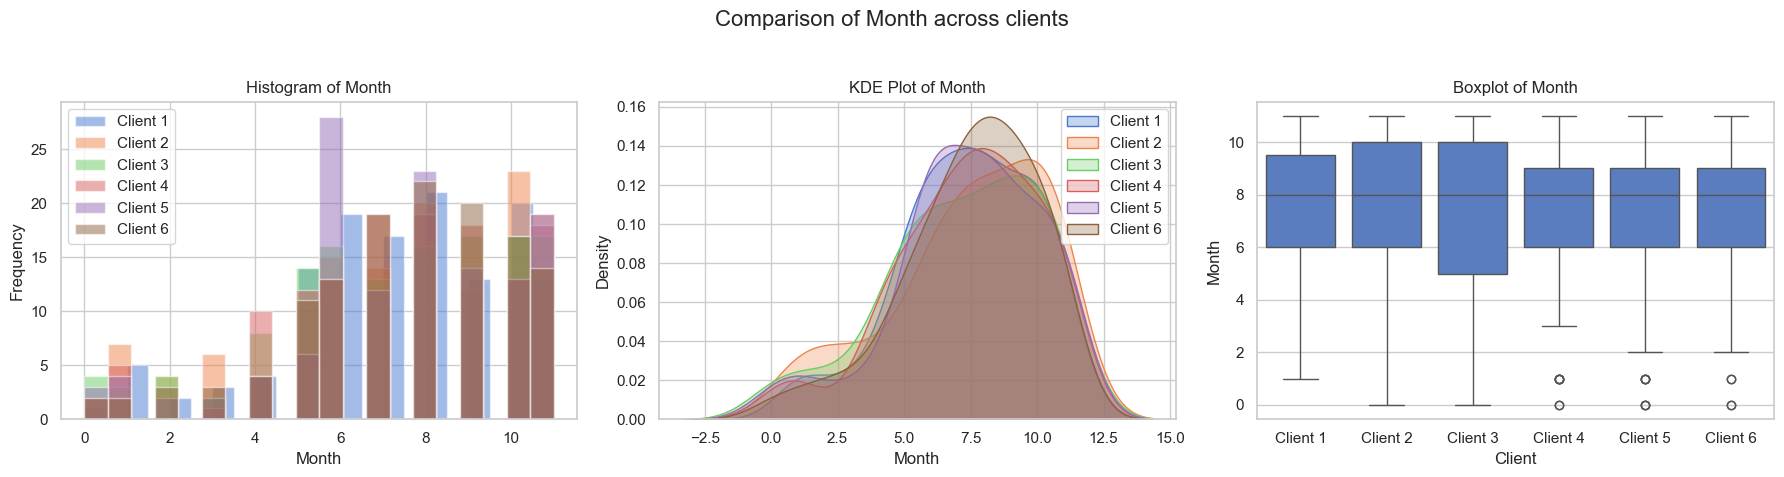

In [86]:
plotting_month(df_list=chunks
         )

In [73]:
cl_1, cl_2, cl_3, cl_4, cl_5, cl_6 = client_datasets[0], client_datasets[1], client_datasets[2], client_datasets[3], client_datasets[4], client_datasets[5]

In [3]:
from model import LogisticRegressionModel
from tools import train, eval, prepare_data

In [28]:
test_sample.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeGroup,VehiclePrice_Cat,Fraud
0,3,3,1,13,1,6,8,2,1,0,...,0,0,0,0,1,0,2,-1.0,0,0
1,6,3,0,9,1,7,7,4,1,1,...,0,0,0,0,1,1,1,-1.0,2,0
2,4,4,6,17,1,7,4,1,1,1,...,0,0,0,0,1,0,2,-1.0,1,0
3,4,3,1,13,1,7,4,1,1,1,...,0,0,0,0,1,1,2,-1.0,1,0
4,6,3,1,13,1,2,7,3,1,2,...,0,0,1,0,1,0,1,-1.0,2,0


In [8]:
def local_procces(df):
    train_loader, test_loader, input_dim = prepare_data(df, test_sample.drop(columns="Fraud"), test_sample.Fraud)
    model = LogisticRegressionModel(input_dim=input_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train(model=model, train_loader=train_loader,lr=0.01, num_epochs=10, device=device)
    metrics = eval(model=model, test_loader=test_loader, device=device)
    return metrics

In [9]:
[type(i) for i in client_datasets.values()]

[pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame]

In [10]:
six_client_metrics = []
[six_client_metrics.append(local_procces(_)) for _ in client_datasets.values()] 

[None, None, None, None, None, None]

In [11]:
six_client_metrics

[{'logloss_test': 0.5117739602858961,
  'roc_auc_test': 0.7809770107661931,
  'accuracy_test': 0.6799610894941635,
  'f1_test': 0.21852731591448932},
 {'logloss_test': 0.5246201489666101,
  'roc_auc_test': 0.7834147418484408,
  'accuracy_test': 0.687094682230869,
  'f1_test': 0.2236524537409493},
 {'logloss_test': 0.4062640272619373,
  'roc_auc_test': 0.7877147040246996,
  'accuracy_test': 0.7616731517509727,
  'f1_test': 0.2367601246105919},
 {'logloss_test': 0.6144541846446949,
  'roc_auc_test': 0.7588075929803478,
  'accuracy_test': 0.6666666666666666,
  'f1_test': 0.22822822822822822},
 {'logloss_test': 0.6993187012572554,
  'roc_auc_test': 0.7563047109560357,
  'accuracy_test': 0.6151102464332037,
  'f1_test': 0.2070808283233133},
 {'logloss_test': 0.48236655267974604,
  'roc_auc_test': 0.7617249073861261,
  'accuracy_test': 0.7370298313878081,
  'f1_test': 0.22094140249759847}]

In [17]:
num = [i for i in range(1,7)]
for j, i in zip(a, client_datasets.values()):
    i.to_csv(os.path.join("data", f"noniid_df_{j}.csv"))

In [20]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'PolicyNumber', 'RepNumber', 'Deductible',
       'DriverRating', 'Days_Policy_Accident', 'Days_Policy_Claim',
       'PastNumberOfClaims', 'AgeOfVehicle', 'PoliceReportFiled',
       'WitnessPresent', 'AgentType', 'NumberOfSuppliments',
       'AddressChange_Claim', 'NumberOfCars', 'Year', 'BasePolicy', 'AgeGroup',
       'VehiclePrice_Cat', 'Fraud'],
      dtype='object')

In [55]:
# results = {
# f"{len(features.to_list())}_features": [
#         local_procces(client_df)
#         for client_df in feature_skew_split(data, features.to_list(), target_col="Fraud").values()
#     ]
#     for features in features_set
# }


In [69]:
results

{'5_features': [{'logloss_test': 0.5015528307451095,
   'roc_auc_test': 0.7647489969469545,
   'accuracy_test': 0.6880674448767834,
   'f1_test': 0.21661237785016288},
  {'logloss_test': 0.5034341565817322,
   'roc_auc_test': 0.7766770485899345,
   'accuracy_test': 0.7169260700389105,
   'f1_test': 0.224},
  {'logloss_test': 0.6022305539187666,
   'roc_auc_test': 0.772382515658848,
   'accuracy_test': 0.6507782101167315,
   'f1_test': 0.22795698924731184},
  {'logloss_test': 0.5506164834309755,
   'roc_auc_test': 0.7819597041423331,
   'accuracy_test': 0.6605058365758755,
   'f1_test': 0.23184152604548788},
  {'logloss_test': 0.3994843422508203,
   'roc_auc_test': 0.7019398692999712,
   'accuracy_test': 0.8132295719844358,
   'f1_test': 0.2087912087912088},
  {'logloss_test': 0.49171424914945255,
   'roc_auc_test': 0.7298262822519785,
   'accuracy_test': 0.7477302204928664,
   'f1_test': 0.21095334685598377}],
 '6_features': [{'logloss_test': 0.5776406127334913,
   'roc_auc_test': 0.76

[None, None, None, None, None, None]

In [70]:
dfs = {prefix: pd.DataFrame(metrics_list) for prefix, metrics_list in results.items()}

In [74]:
dfs.keys()

dict_keys(['5_features', '6_features', '7_features', '8_features', '9_features', '10_features', '11_features', '12_features', '13_features', '14_features', '15_features', '16_features', '17_features', '18_features', '19_features'])

In [99]:
for key in sorted(dfs.keys(), key=lambda x: int(x.split('_')[0])):
    print(f"{key}:")
    print(dfs[key])
    print("\n")
 

5_features:
   logloss_test  roc_auc_test  accuracy_test   f1_test
0      0.501553      0.764749       0.688067  0.216612
1      0.503434      0.776677       0.716926  0.224000
2      0.602231      0.772383       0.650778  0.227957
3      0.550616      0.781960       0.660506  0.231842
4      0.399484      0.701940       0.813230  0.208791
5      0.491714      0.729826       0.747730  0.210953


6_features:
   logloss_test  roc_auc_test  accuracy_test   f1_test
0      0.577641      0.760735       0.666342  0.216299
1      0.545273      0.759278       0.697147  0.217755
2      0.558487      0.778116       0.685798  0.227888
3      0.418201      0.781516       0.766537  0.234043
4      0.447604      0.734311       0.773995  0.217733
5      0.432648      0.746927       0.785019  0.229965


7_features:
   logloss_test  roc_auc_test  accuracy_test   f1_test
0      0.492783      0.789968       0.708171  0.230769
1      0.518805      0.781690       0.685798  0.230342
2      0.540752      0.75

In [6]:
df_1 = pd.read_csv(os.path.join("data", "df1.csv"))

In [8]:
df_1.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,AgeGroup,VehiclePrice_Cat,Fraud
0,7,5,4,17,1,5,1,4,1,1,...,0,0,0,0,1,0,0,-1.0,1,1
1,10,2,1,13,1,2,11,3,0,2,...,0,0,1,0,1,2,1,-1.0,1,0
2,7,4,0,5,1,1,1,1,1,3,...,0,0,6,0,1,2,0,-1.0,1,0
3,0,3,2,13,0,7,9,1,1,1,...,0,0,1,0,1,0,1,-1.0,1,0
4,5,3,4,9,1,1,2,1,1,1,...,0,0,0,0,1,2,2,-1.0,2,0


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, optimizer, criterian, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.to(DEVICE)
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterian(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import DataLoader
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, f1_score

# Инициализация wandb
wandb.init(project="my-first-project")

def objective(trial):
    # Определение гиперпараметров для поиска
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "AdamW"])
    
    # Подготовка данных
    train_loader, test_loader, input_dim = prepare_data(train_data, test_data.drop(columns="Fraud"), test_data.Fraud)
    model = LogisticRegressionModel(input_dim=input_dim)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Выбор оптимизатора
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    # Функция потерь
    criterion = nn.CrossEntropyLoss()
    
    # Обучение модели
    num_epochs = 5
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Оценка модели
    model.eval()
    test_labels = []
    test_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            test_labels.extend(labels.cpu().numpy())
            test_predictions.extend(probabilities.cpu().numpy())
    
    # Метрики качества
    try:
        test_logloss = log_loss(test_labels, test_predictions)
        test_roc_auc = roc_auc_score(test_labels, test_predictions)
        test_pred_binary = np.array(test_predictions) > 0.5
        test_accuracy = accuracy_score(test_labels, test_pred_binary)
        test_f1 = f1_score(test_labels, test_pred_binary)
        
        # Логирование параметров и метрик в wandb
        wandb.log({
            "lr": lr,
            "optimizer": optimizer_name,
            "roc_auc": test_roc_auc,
            "accaracy": test_accuracy,
            "f1_score": test_f1,
            "log_loss": test_logloss,
        })
        
        return test_roc_auc  # Оптимизируем roc_auc
    except ValueError:
        return float("-inf")  # Возвращаем -inf в случае ошибки


# Запуск оптимизации
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Вывод лучших параметров
print("Best hyperparameters:", study.best_params)

# Завершение логирования
wandb.finish()


[I 2025-02-20 21:47:29,561] A new study created in memory with name: no-name-941d983d-7f2b-4dfa-9430-709fc311fbf6
C:\Users\Астемир\AppData\Local\Temp\ipykernel_17388\1813763819.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2025-02-20 21:47:37,551] Trial 0 finished with value: 0.8002725481076366 and parameters: {'lr': 0.05753027348692624, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.8002725481076366.
C:\Users\Астемир\AppData\Local\Temp\ipykernel_17388\1813763819.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)
[I 2025-02-20 21:47:45,290] Trial 1 finished wi

KeyboardInterrupt: 